<h1> <img style="height:5em;" alt="batty" src="https://raw.githubusercontent.com/philippeller/batty/main/batty_logo.svg"/> </h1> 

# BAT to Python (batty)

A small python interface to the Bayesian Analysis Toolkit (BAT.jl) https://github.com/bat/BAT.jl


* Please check out the minimal example to get started [below](#minimal-example)
* To understand how to define a prior + likelihood, please read [this](#specifying-priors-and-likelihoods)
* For experimental support of gradients, see [this](#hmc-with-gradients)

# Quick Start

## Installation

There are two parts to an installation, one concerning the python side, and one the julia side:

* Python: `pip install batty`

* Julia: `import Pkg; Pkg.add(["PyJulia", "DensityInterface", "Distributions", "ValueShapes", "TypedTables", "ArraysOfArrays", "ChainRulesCore", "BAT"])`

sampler.findmodeExample

The code below is showing a minimal example:
* using a gaussian likelihood and a uniform prior
* generating samples via Metropolis-Hastings
* plotting the resulting sampes
* <s>estimating the integral value via BridgeSampling</s>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from batty import BAT_sampler, BAT, Distributions, jl
import juliacall

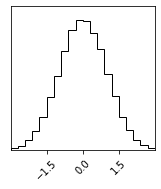

In [3]:
sampler = BAT_sampler(llh=lambda x : -0.5 * x**2, prior_specs=Distributions.Uniform(-3, 3))
sampler.sample();
sampler.corner();

# Usage

## Using Different Algotihms

There are a range of algorihtms available within BAT, and those can be further customized via arguments. Here are just a few examples:

### MCMC Sampling:

In [4]:
results = {}

* Metropolis-Hastings:

In [5]:
results['Metropolis-Hastings'] = sampler.sample(strategy=BAT.MCMCSampling(nsteps=10_000, nchains=2))

* Metropolis-Hastings with Accept-Reject weighting:

In [6]:
results['Accept-Reject Weighting'] = sampler.sample(strategy=BAT.MCMCSampling(mcalg=BAT.MetropolisHastings(weighting=BAT.ARPWeighting()), nsteps=10_000, nchains=2))

* Prior Importance Sampling:

In [7]:
results['Prior Importance Sampling'] = sampler.sample(strategy=BAT.PriorImportanceSampler(nsamples=10_000))

* Sobol Sampler:

In [8]:
results['Sobol Quasi Random Numbers'] = sampler.sample(strategy=BAT.SobolSampler(nsamples=10_000))

* Grid Sampler:

In [9]:
results['Grid Points'] = sampler.sample(strategy=BAT.GridSampler(ppa=1000))

Plotting the different results:

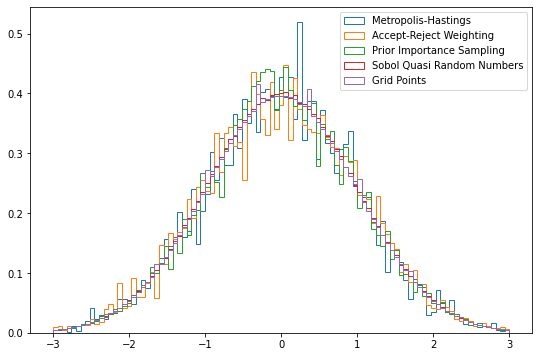

In [10]:
fig = plt.figure(figsize=(9,6))
bins=np.linspace(-3, 3, 100)
for key, item in results.items():
    plt.hist(item.v, weights=item.weight, bins=bins, density=True, histtype="step", label=key);
plt.legend()

# Specifying Priors and Likelihoods

Priors are specified via Julia `Distributions`, multiple Dimensions can be defined via a `dict`, where the `key` is the dimension name and the value the distribution, or as a list in case flat vectors with paraeter names are used.

Below the example *with* parameter names

In [11]:
s = np.array([[0.25, 0.4], [0.9, 0.75]])
prior_specs = {'a' : Distributions.Uniform(-3,3), 'b' : Distributions.MvNormal(np.array([1.,1.]), jl.Array(s@s.T))}

The log-likelihood (`llh`) can be any python callable, that returns the log-likelihood values. The first argument to the function is the object with paramneter values, here `x`. If the prior is simple (i.e. like in the example in the beginning, `x` is directly the parameter value). If the prior is specified via a `dict`, then `x` contains a field per parameter with the value.
Any additional `args` to the llh can be given in the sampler, such as here `d` for data:

In [12]:
def llh(x, d):
    return -0.5 * ((x.b[0] - d[0])**2 + (x.b[1] - d[1])**2/4) - x.a

Or alternatively *without* parameter names (this will result in a flat vector):

In [13]:
# prior_specs = [Distributions.Uniform(-3,3), Distributions.MvNormal(np.array([1.,1.]), jl.Array(s@s.T))]
# def llh(x, d):
#     return -0.5 * ((x[1] - d[0])**2 + (x[2] - d[1])**2/4) - x[0]

In [14]:
d = [-1, 1]

In [15]:
sampler = BAT_sampler(llh=llh, prior_specs=prior_specs, llh_args=(d,))

Let us generate a few samples:

In [16]:
sampler.sample(strategy=BAT.MCMCSampling(nsteps=10_000, nchains=2));

### Some interface to plotting tools are available

* The **G**reat **T**riangular **C**onfusion (GTC) plot:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


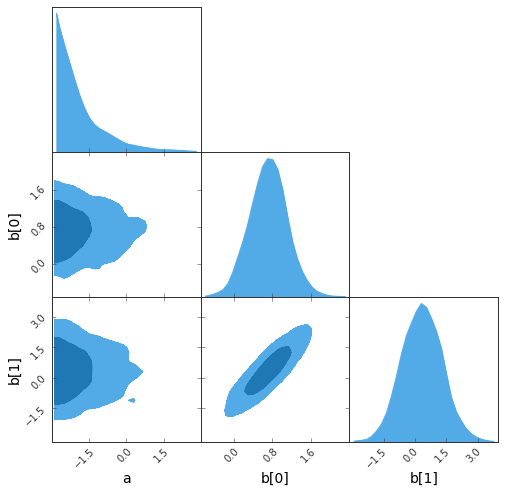

In [17]:
sampler.gtc(figureSize=8, customLabelFont={'size':14}, customTickFont={'size':10});

* The corner plot:

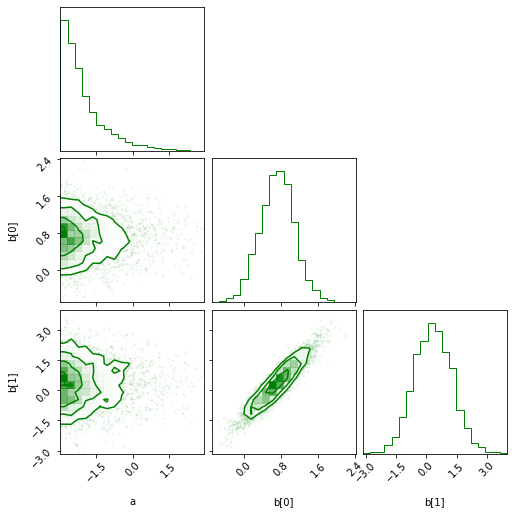

In [18]:
sampler.corner(color='green');

## HMC with Gradients

First let's look at an example using flat vectors:

In [19]:
llh = lambda x : -0.5 * np.dot(x, x)
grad = lambda x : -x
sampler = BAT_sampler(llh=llh, prior_specs=[Distributions.Uniform(-3, 3),], grad=grad, )

# Or alternatively:
# llh_and_grad = lambda x: (-0.5 * np.dot(x, x), -x)
# sampler = BAT_sampler(llh=llh, prior_specs=[Distributions.Uniform(-3, 3),], llh_and_grad=llh_and_grad)

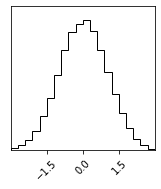

In [20]:
sampler.sample(strategy=BAT.MCMCSampling(mcalg=BAT.HamiltonianMC()));
sampler.corner();

In [21]:
sampler.findmode()

(result = [0.00012339715218110216], result_trafo = [0.00012339715218110216], trafo = identity ∘ identity, trace_trafo = NamedTuple{(:v,), Tuple{Vector{Float64}}}[(v = [2.5003780712463737],), (v = [2.5003780712463737],), (v = [1.225189035623187],), (v = [-0.04999999999999982],), (v = [-0.04999999999999982],), (v = [0.02969931472644935],), (v = [0.009774486044837057],), (v = [0.004793278874433983],), (v = [-0.00018792829596908991],), (v = [-0.00018792829596908991],)], info = Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [2.5003780712463737]
 * Maximizer: [0.00012339715218110216]
 * Maximum: -1.791759e+00
 * Iterations: 9
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 21, optargs = (algorithm = NelderMeadOpt{DoNotTransform, InitFromTarget}
  trafo: DoNotTransform DoNotTransform()
  init: InitFromTarget InitFromTarget()
,), kwargs = NamedTuple())

In [22]:
sampler.findmode(BAT.LBFGSOpt())

(result = [4.654232554912596e-11], result_trafo = [1.9443995892542976e-11], trafo = DistributionTransform(BAT.StandardMvNormal{Float64}(_dim=1), ValueShapes.UnshapedNTD{NamedTupleDist{(:p0,), Tuple{Uniform{Float64}}, Tuple{ValueAccessor{ScalarShape{Real}}}, NamedTuple}}(
shaped: NamedTupleDist((p0 = Uniform{Float64}(a=-3.0, b=3.0),))
)
), trace_trafo = NamedTuple{(:v, :logd, :grad_logd), Tuple{Vector{Float64}, Float64, Vector{Float64}}}[(v = [-0.6587150350244174], logd = -2.21599390599995, grad_logd = [3.4906771750114083]), (v = [0.23765672881802102], logd = -1.105977679254204, grad_logd = [-1.5490570022891985]), (v = [0.001027968548749203], logd = -0.9189420888411827, grad_logd = [-0.006917790331040427]), (v = [1.9443995892542976e-11], logd = -0.9189385332046728, grad_logd = [-1.3085020483106803e-10])], info = Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.6587150350244174]
 * Maximizer: [1.9443995892542976e-11]
 * Maximum: -9.189385e-01
 * Iterations: 3

Or with parameter names (here the gradient function needs to be able to return named tuples!):

In [23]:
from collections import namedtuple
prior = {'a':Distributions.Uniform(-3, 3), 'b': Distributions.Cauchy()}
llh = lambda x : -0.5 * x.a**2 + x.b
    
v = namedtuple('v', 'a b')

def grad(x):
    return v(a = -x.a, b=1.)

In [24]:
sampler = BAT_sampler(llh=llh, prior_specs=prior, grad=grad, )

In [25]:
sampler.findmode(BAT.LBFGSOpt())

(result = (a = -2.774359870100099, b = 1.3748233863972102e15), result_trafo = [-1.779160961167169, 8.292361075813613], trafo = DistributionTransform(BAT.StandardMvNormal{Float64}(_dim=2), NamedTupleDist{(:a, :b)}(…)), trace_trafo = NamedTuple{(:v, :logd, :grad_logd), Tuple{Vector{Float64}, Float64, Vector{Float64}}}[(v = [-1.2587536135732944, -1.7223257853024079], logd = -14.379301063532187, grad_logd = [3.8337762241448323, 17.76625871401564]), (v = [0.7635387123418593, 7.649261536696631], logd = 3.1433087080088902e13, grad_logd = [-3.740473440116247, 2.4394275174682822e14]), (v = [0.7635382664426248, 2.908025324267957e7], logd = 9.519928220680188e14, grad_logd = [-3.740472581583452, -2.908025324267957e7]), (v = [-2.314123355320277, 5.153011945433553e6], logd = 1.361546620342311e15, grad_logd = [2.797466899034834, -5.153011945433553e6]), (v = [0.35941433317089366, 1.2642107455691537e6], logd = 1.3740242719926018e15, grad_logd = [-2.2491330410508144, -1.2642107455691537e6]), (v = [-1.90

Or a simple llh with no vector nor tuple:

In [26]:
llh = lambda x : -0.5 * np.dot(x, x)
grad = lambda x : -x
sampler = BAT_sampler(llh=llh, prior_specs=Distributions.Uniform(-3, 3), grad=grad, )

In [27]:
sampler.findmode(BAT.LBFGSOpt())

(result = -4.440892098500626e-16, result_trafo = [-9.599424391232986e-17], trafo = Base.Fix2{typeof(unshaped), ScalarShape{Real}}(ValueShapes.unshaped, ScalarShape{Real}()) ∘ DistributionTransform(BAT.StandardUvNormal{Float64}(), Uniform{Float64}(a=-3.0, b=3.0)), trace_trafo = NamedTuple{(:v, :logd, :grad_logd), Tuple{Vector{Float64}, Float64, Vector{Float64}}}[(v = [0.19839644385007574], logd = -1.0499145108671066, grad_logd = [-1.3057027231751668]), (v = [-0.1257368729646586], logd = -0.9718972381306173, grad_logd = [0.8386048377455525]), (v = [-9.167475784471746e-6], logd = -0.9189385334874584, grad_logd = [6.169324290536366e-5]), (v = [-9.599424391232986e-17], logd = -0.9189385332046728, grad_logd = [1.1589900163878561e-15])], info = Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.19839644385007574]
 * Maximizer: [-9.599424391232986e-17]
 * Maximum: -9.189385e-01
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 9.17e